In [1]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

c:\Users\Usuario\.conda\envs\PyG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [80]:
data_dir = 'C:/Users/Usuario/Desktop/bdata3/RETO_10/health/data'

In [81]:
img_size = (64, 64)

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5]),
])

In [82]:
dataset = ImageFolder(data_dir, transform=transform)

train_size = int(0.7 * len(dataset))
validation_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(
    dataset, [train_size, validation_size, test_size]
)

In [83]:
trainloader = DataLoader(train_dataset, shuffle=True, num_workers=2)
validationloader = DataLoader(validation_dataset, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, shuffle=False, num_workers=2)

In [84]:
class Net(nn.Module):
	
    def __init__(self):
        super(Net, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 13 * 13, 84)
        self.dropout = nn.Dropout(p=.5) 
        self.fc2 = nn.Linear(84,  len(dataset.classes))

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=84, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=84, out_features=2, bias=True)
)


In [85]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [86]:
def train():
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        net.train()
        optimizer.zero_grad()  
        out = net(inputs) 
        loss = criterion(out, labels) 
        loss.backward()  
        optimizer.step() 
    return loss.item()

def test(loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            out = net(inputs)
            pred = out.argmax(dim=1)  
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    return acc

for epoch in range(1, 11):
    train_loss = train()
    train_acc = test(trainloader)
    val_acc = test(validationloader)
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}')


Epoch: 001, Loss: 0.7427, Train: 0.5200, Val: 0.6190
Epoch: 002, Loss: 0.4214, Train: 0.6133, Val: 0.6190
Epoch: 003, Loss: 0.0053, Train: 0.9867, Val: 0.9048
Epoch: 004, Loss: 0.0000, Train: 0.8933, Val: 0.9048
Epoch: 005, Loss: 0.0000, Train: 1.0000, Val: 0.9524
Epoch: 006, Loss: 0.0646, Train: 1.0000, Val: 0.9524
Epoch: 007, Loss: 0.0000, Train: 1.0000, Val: 0.9524
Epoch: 008, Loss: 0.0004, Train: 1.0000, Val: 0.9524
Epoch: 009, Loss: 0.0000, Train: 1.0000, Val: 0.9524
Epoch: 010, Loss: 0.0000, Train: 1.0000, Val: 0.9524


In [90]:
test_acc = test(testloader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 1.0000


In [91]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

class_at_index_0 = idx_to_class[0]
class_at_index_1 = idx_to_class[1]

print("\nClase en el índice 0:", class_at_index_0)
print("Clase en el índice 1:", class_at_index_1)



Clase en el índice 0: LLA
Clase en el índice 1: healthy


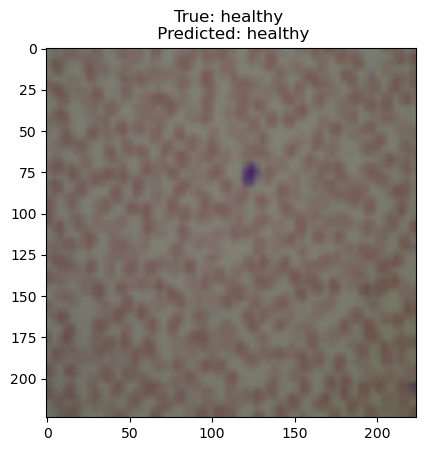

In [93]:
inv_normalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
inv_transform = transforms.Compose([
    transforms.Resize((224,224)),
    inv_normalize,
    transforms.ToPILImage()
])


sample_image, sample_label = test_dataset[10]

net.eval()

with torch.no_grad():
    output = net(sample_image)

predicted_class = torch.argmax(output, dim=1).item()
img_original = inv_transform(sample_image)

plt.imshow(img_original)
plt.title(f"True: {'healthy' if sample_label == 1 else 'LLA'} \n Predicted: {'healthy' if predicted_class == 1 else 'LLA'}")
plt.show()


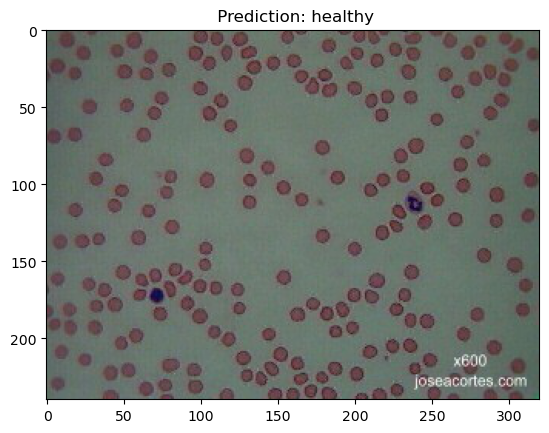

In [109]:
from PIL import Image
img_size = (224, 224)

new_data_dir = 'C:/Users/Usuario/Desktop/bdata3/RETO_10/health/data_pruebas/4.jpg'
img = Image.open(new_data_dir)

img_transformed = transform(img)
output = net(img_transformed)
predicted_class = torch.argmax(output, dim=1).item()


plt.imshow(img)
plt.title(f" Prediction: {'healthy' if predicted_class == 1 else 'LLA'}")
plt.show()